# B1 correction

The MP2RAGE images are still biased by the B1 transmit field inhomogenieties. A B1 map (Acquired using e.g. a SA2RAGE or a DREAM sequence) can be used to correct for this (see Marques et al., 2013). 

Marques, J. P., & Gruetter, R. (2013). New Developments and Applications of the MP2RAGE Sequence - Focusing the Contrast and High Spatial Resolution R1 Mapping. Plos One, 8(7), e69294–11. http://doi.org/10.1371/journal.pone.0069294


First let's load some data.

In [1]:
from pymp2rage import MP2RAGE

mp2rage = MP2RAGE(MPRAGE_tr=6.723,
                           invtimesAB=[0.67, 3.855],
                           flipangleABdegree=[7, 6],
                           nZslices=150,
                           FLASH_tr=[0.0062, 0.0320],
                           inv1='/data/sourcedata/sub-012/anat/sub-012_acq-highres0p64ME_INV1.nii',
                           inv1ph='/data/sourcedata/sub-012/anat/sub-012_acq-highres0p64ME_INV1ph.nii',
                           inv2='/data/sourcedata/sub-012/anat/sub-012_acq-highres0p64ME_INV2.nii',                       
                           inv2ph='/data/sourcedata/sub-012/anat/sub-012_acq-highres0p64ME_INV2ph.nii')



Using the `plot_b1_effects`-function we can see how much a flip angle that is different from the intended flip angle biases the T1 estimates (and T1w image).

[-9.1394043620689018,
 -10.150176201516871,
 -9.6829488581587206,
 -8.4606895139711771,
 -7.0011608880218725]

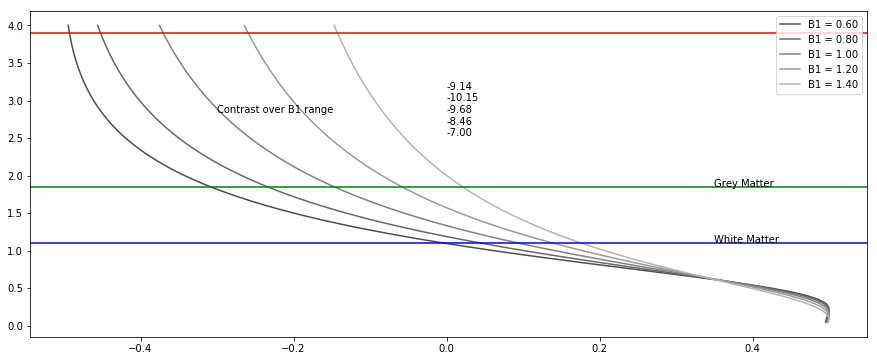

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 6))
mp2rage.plot_B1_effects()

As you can see, for a given MP2RAGE signal intensity of -0.2, the T1 values can ahve a range of approximately 1.5 s to more than 4 seconds. This makes quite a difference!

Luckily, we also acquired a B1-fieldmap, that shows, for every voxel, the ratio between intended and real flip angle.

In [3]:
import nibabel as nb
b1_map = nb.load('/data/sourcedata/sub-012/anat/sub-012_acq-highres0p64ME_B1_resampled.nii.gz')

from nilearn import plotting


/usr/local/miniconda/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


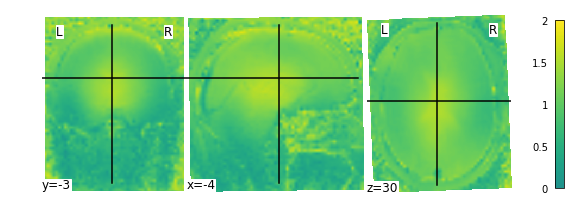

In [4]:
plotting.plot_stat_map(b1_map, None, cmap=plt.cm.viridis)

As you can see the B1 is quite different in the center from the brain, compared to the inside of the brain!

# Correct for B1

We can use the `correct_for_B1`-method to correct for B1 inhomogeneities using the B1 fieldmap.

It returns both a B1-corrected quantiative T1 map, as well as a B1-corrected T1-weighted (mp2rage) image.

*Note that it is very important that the B1-fieldmap is registered to the same space as the MP2RAGE images*

In [5]:
t1_corrected, t1w_corrected = mp2rage.correct_for_B1('/data/sourcedata/sub-012/anat/sub-012_acq-highres0p64ME_B1_resampled.nii.gz')

/home/neuro/git/pymp2rage/pymp2rage/mp2rage.py:174: RuntimeWarning: invalid value encountered in true_divide
  self._t1w_uni = (np.real(compINV1*compINV2/(compINV1**2 + compINV2**2)))*4095+2048


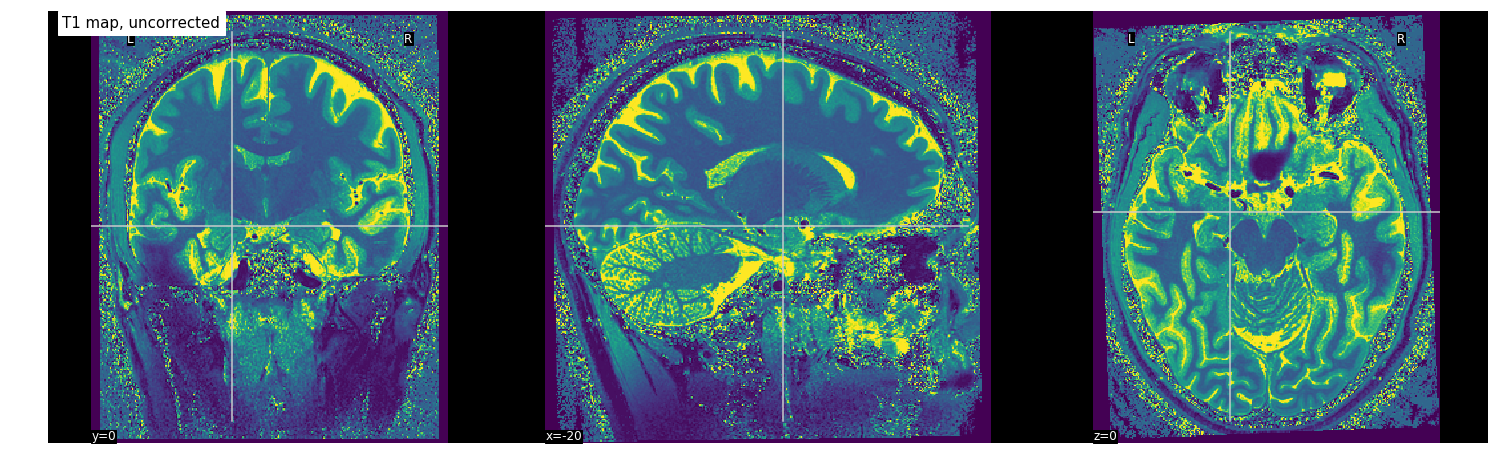

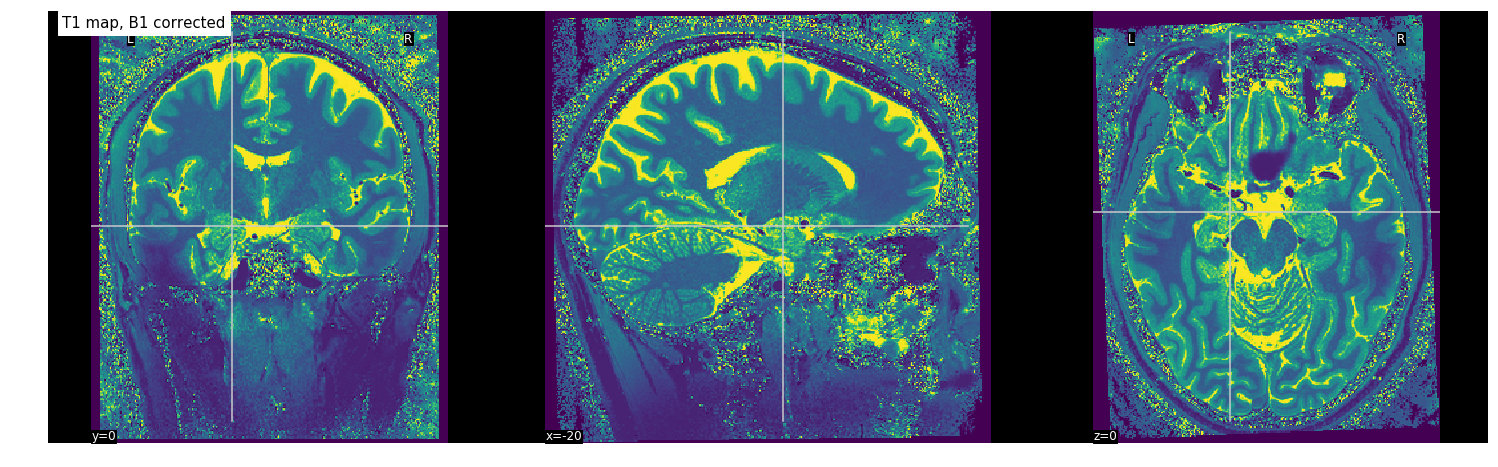

In [6]:
fig = plt.figure(figsize=(20, 6))
plotting.plot_anat(mp2rage.t1, cut_coords=(-20, 0, 0), cmap=plt.cm.viridis, title='T1 map, uncorrected', figure=fig, vmin=0, vmax=4000, )

fig = plt.figure(figsize=(20, 6))
plotting.plot_anat(t1_corrected, cut_coords=(-20, 0, 0), cmap=plt.cm.viridis, title='T1 map, B1 corrected', figure=fig, vmin=0, vmax=4000)

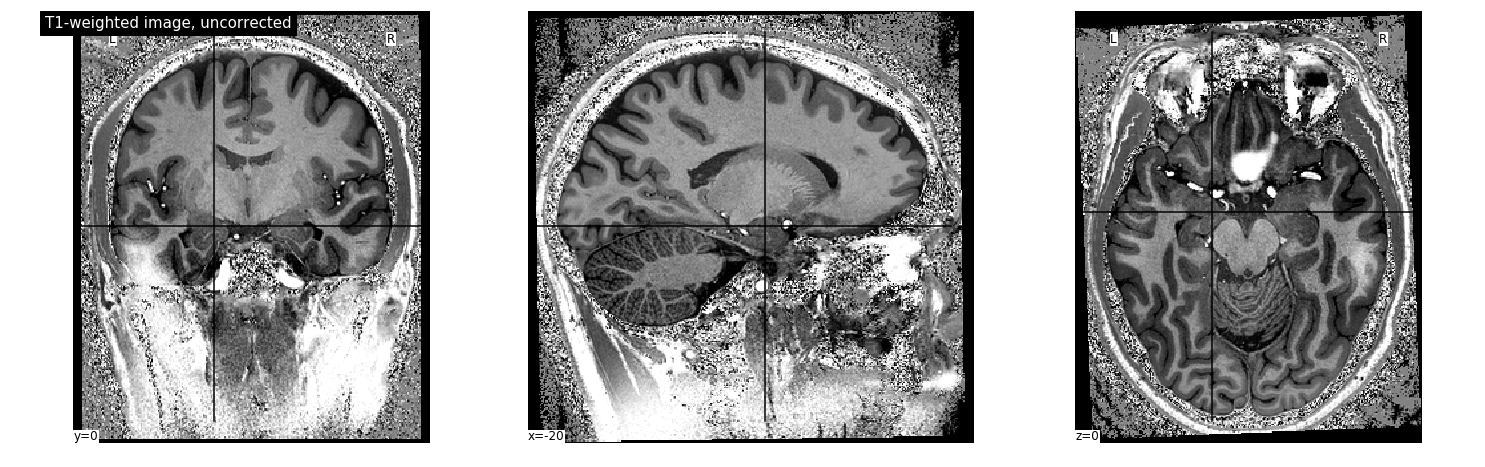

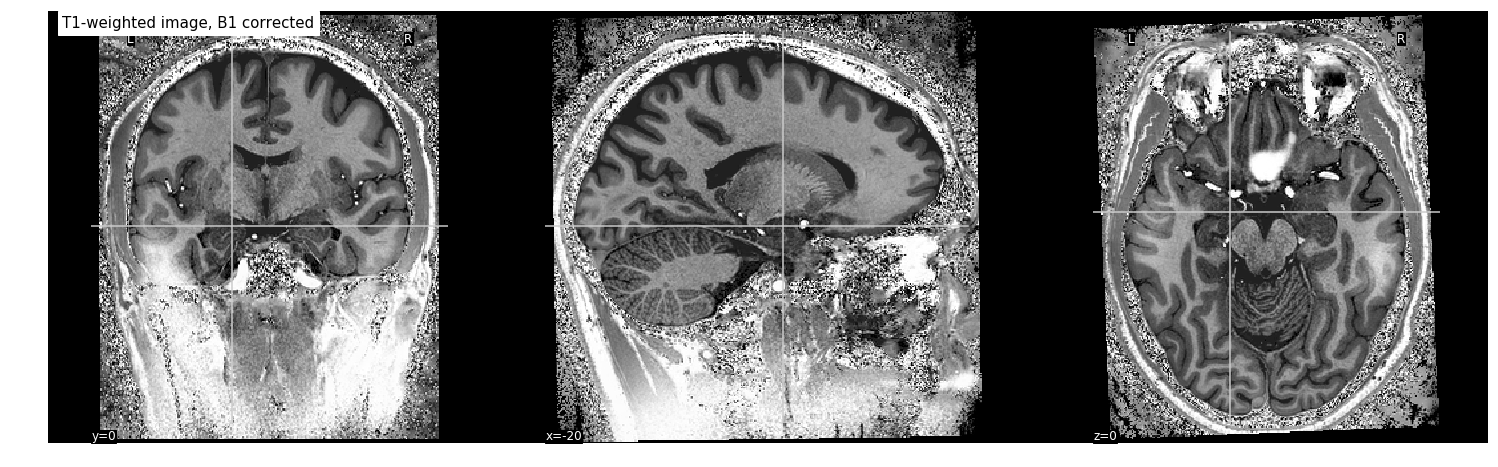

In [7]:
fig = plt.figure(figsize=(20, 6))
plotting.plot_anat(mp2rage.t1w_uni,  cut_coords=(-20, 0, 0), vmin=0, vmax=4000, figure=fig, title='T1-weighted image, uncorrected')

fig = plt.figure(figsize=(20, 6))
plotting.plot_anat(t1w_corrected,  cut_coords=(-20, 0, 0), vmin=0, vmax=4000, figure=fig, title='T1-weighted image, B1 corrected')

Here we plot the difference image from the B1-corrected and uncorrected T1-weighted image

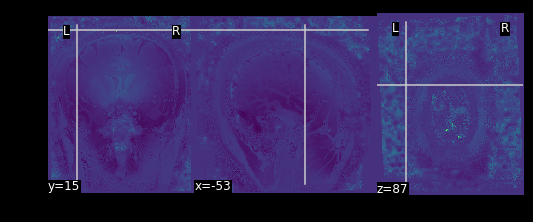

In [8]:
from nilearn import image
difference = image.math_img('t1w - t1w_corrected', t1w=mp2rage.t1w_uni, t1w_corrected=t1w_corrected)
plotting.plot_anat(difference, cmap=plt.cm.viridis)

These images are now also stored into the MP2RAGE-object:

In [9]:
mp2rage.t1w_uni_b1_corrected

In [10]:
mp2rage.t1_b1_corrected

If we ask the MP2RAGE-object to write its files, it will also write away the B1-corrected files

In [11]:
mp2rage.write_files()

Writing T1 map to /data/sourcedata/sub-012/anat/sub-012_acq-highres0p64ME_T1map.nii.gz
Writing bias-field corrected T1-weighted image to /data/sourcedata/sub-012/anat/sub-012_acq-highres0p64ME_T1w.nii.gz
Writing B1-corrected T1 map to /data/sourcedata/sub-012/anat/sub-012_acq-highres0p64ME_T1map_b1corrected.nii.gz
Writing B1-corrected T1-weighted image to /data/sourcedata/sub-012/anat/sub-012_acq-highres0p64ME_T1w_b1corrected.nii.gz
